In [2]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [3]:
# Carregamento do dataset
df_planosaude = pd.read_csv('data/planosaude.csv', delimiter=',')

# Características das variáveis do dataset
df_planosaude.info()

# Estatísticas univariadas
df_planosaude.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       200 non-null    int64  
 1   despmed  200 non-null    float64
 2   idade    200 non-null    int64  
 3   dcron    200 non-null    int64  
 4   renda    200 non-null    float64
 5   plano    200 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 9.5+ KB


,id,despmed,idade,dcron,renda
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,161.183400,50.010000,2.705000,50.022000
std,57.879185,42.447084,12.547794,1.670908,12.626538
min,1.000000,88.730000,32.000000,0.000000,31.600000
25%,50.750000,126.140000,38.000000,1.000000,38.000000
50%,100.500000,155.000000,49.000000,2.000000,48.800000
75%,150.250000,197.622500,63.000000,4.000000,63.200000
max,200.000000,269.200000,68.000000,5.000000,68.000000


In [5]:
# Tabela de frequências absolutas da variável 'plano'
df_planosaude['plano'].value_counts().sort_index()

plano
bronze       72
esmeralda    66
ouro         62
Name: count, dtype: int64

<Figure size 2000x1000 with 0 Axes>

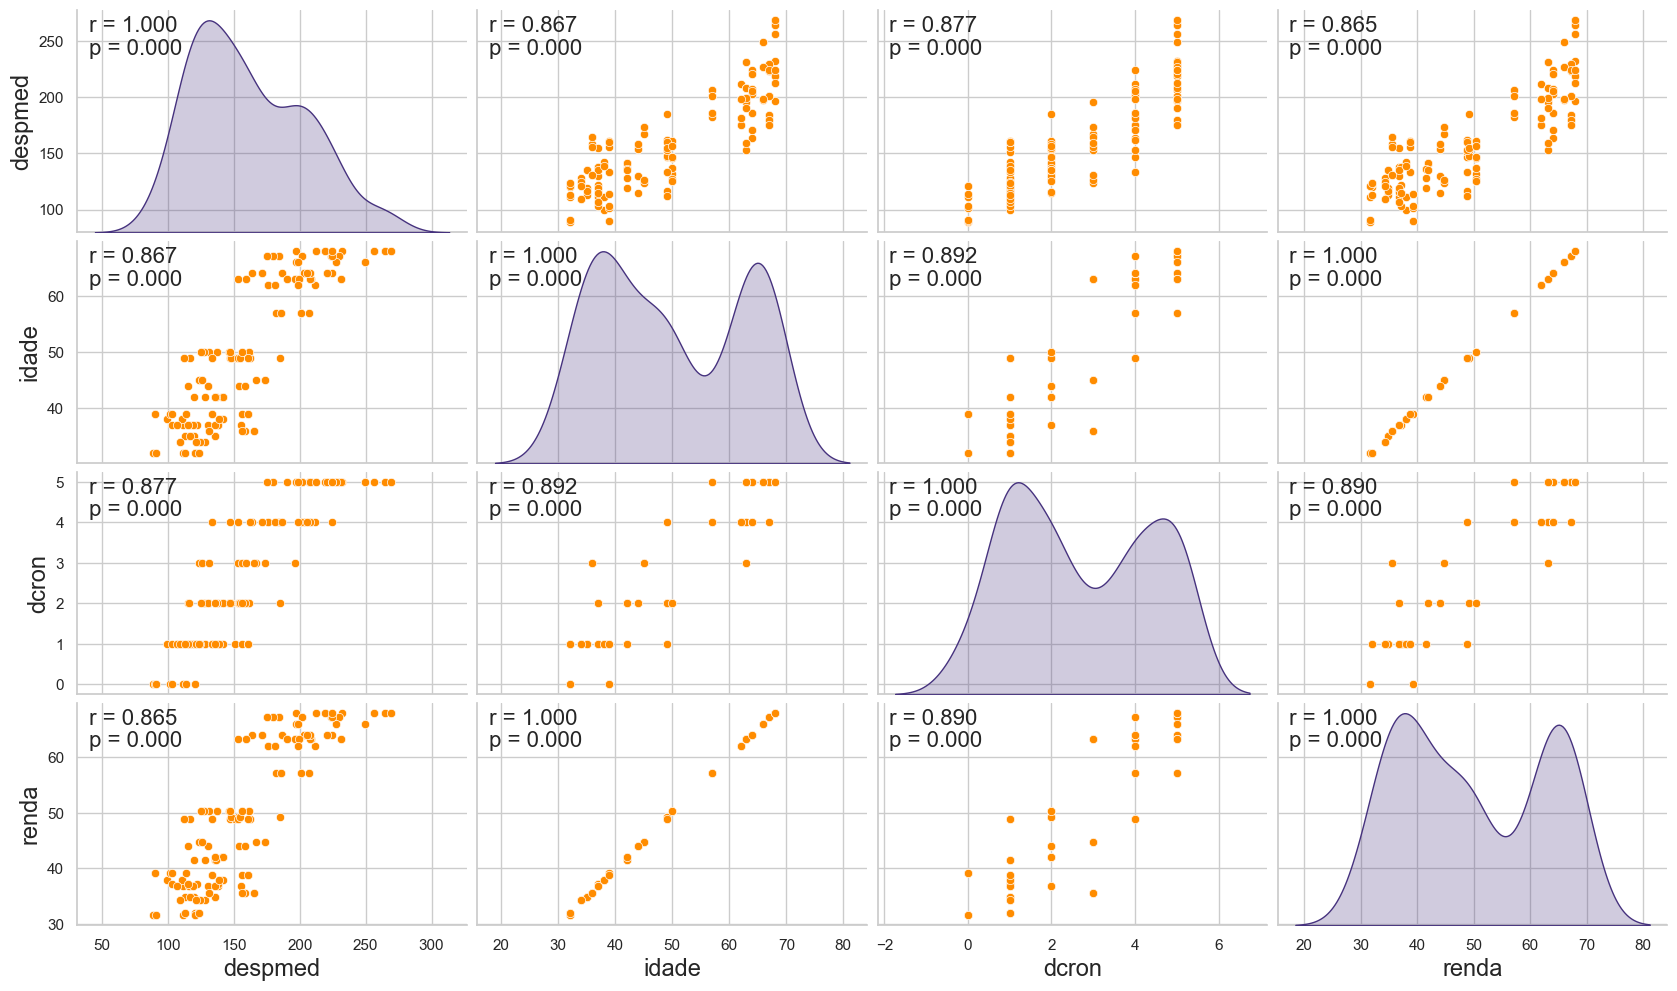

In [7]:
# Distribuições das variáveis, scatters, valores das correlações e
# suas respectivas significâncias

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.03, .9), xycoords=ax.transAxes, fontsize=16)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.03, .8), xycoords=ax.transAxes, fontsize=16)

# Configuração do gráfico
sns.set(style="whitegrid", palette="viridis")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_planosaude.loc[:,'despmed':'renda'], diag_kind="kde",
                     plot_kws={"color": "darkorange"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=17)
    ax.set_ylabel(ax.get_ylabel(), fontsize=17)
plt.show()

In [8]:
# Dummizando a variável 'plano' (n-1 dummies)

df_planosaude_dummies = pd.get_dummies(df_planosaude, columns=['plano'],
                                       dtype=int,
                                       drop_first=True)

df_planosaude_dummies

,id,despmed,idade,dcron,renda,plano_esmeralda,plano_ouro
0,1,206.84,57,5,57.2,0,0
1,2,184.19,67,4,67.2,0,0
2,3,175.68,62,4,62.0,0,0
3,4,180.04,67,5,67.2,0,0
4,5,218.86,68,5,68.0,0,0
...,...,...,...,...,...,...,...
195,196,159.02,63,3,63.2,1,0
196,197,205.35,64,4,64.0,0,0
197,198,133.64,49,4,48.8,1,0
198,199,158.73,44,2,44.0,1,0


In [9]:
# Estimação do modelo de regressão múltipla com n-1 dummies

# Definição da fórmula utilizada no modelo
lista_colunas = list(df_planosaude_dummies.drop(columns=['id',
                                                         'despmed']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "despmed ~ " + formula_dummies_modelo

# Estimação
modelo_planosaude = sm.OLS.from_formula(formula_dummies_modelo,
                                        df_planosaude_dummies).fit()

# Parâmetros do modelo
print(modelo_planosaude.summary())

                            OLS Regression Results                            
Dep. Variable:                despmed   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     262.3
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.88e-84
Time:                        20:49:45   Log-Likelihood:                -828.04
No. Observations:                 200   AIC:                             1668.
Df Residuals:                     194   BIC:                             1688.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         148.8595     12.744     

In [10]:
# Procedimento Stepwise

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.process import stepwise

# Estimação do modelo por meio do procedimento Stepwise
modelo_step_planosaude = stepwise(modelo_planosaude, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 despmed ~ Q('idade') + Q('dcron') + Q('renda') + Q('plano_esmeralda') + Q('plano_ouro')

 Discarding atribute "Q('renda')" with p-value equal to 0.12394354064860003 

Estimating model...: 
 despmed ~ Q('idade') + Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro')

 Discarding atribute "Q('idade')" with p-value equal to 0.11501748716135535 

Estimating model...: 
 despmed ~ Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('renda')", 'p-value': np.float64(0.12394354064860003)}
{'atribute': "Q('idade')", 'p-value': np.float64(0.11501748716135535)}

 Model after stepwise process...: 
 despmed ~ Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro') 

                            OLS Regression Results                            
Dep. Variable:                despmed   R-squared:                       0.868
Model:                         

In [11]:
# Teste de verificação da aderência dos resíduos à normalidade

# Teste de Shapiro-Francia (n >= 30)
# Carregamento da função 'shapiro_francia' do pacote 'statstests.tests'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.tests import shapiro_francia

# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_planosaude.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9429167651264178
statistics z  :  4.609587272596215
p-value  :  2.017345699616686e-06
Statistics W=0.94292, p-value=0.000002
Rejeita-se H0 - Distribuição não aderente à normalidade


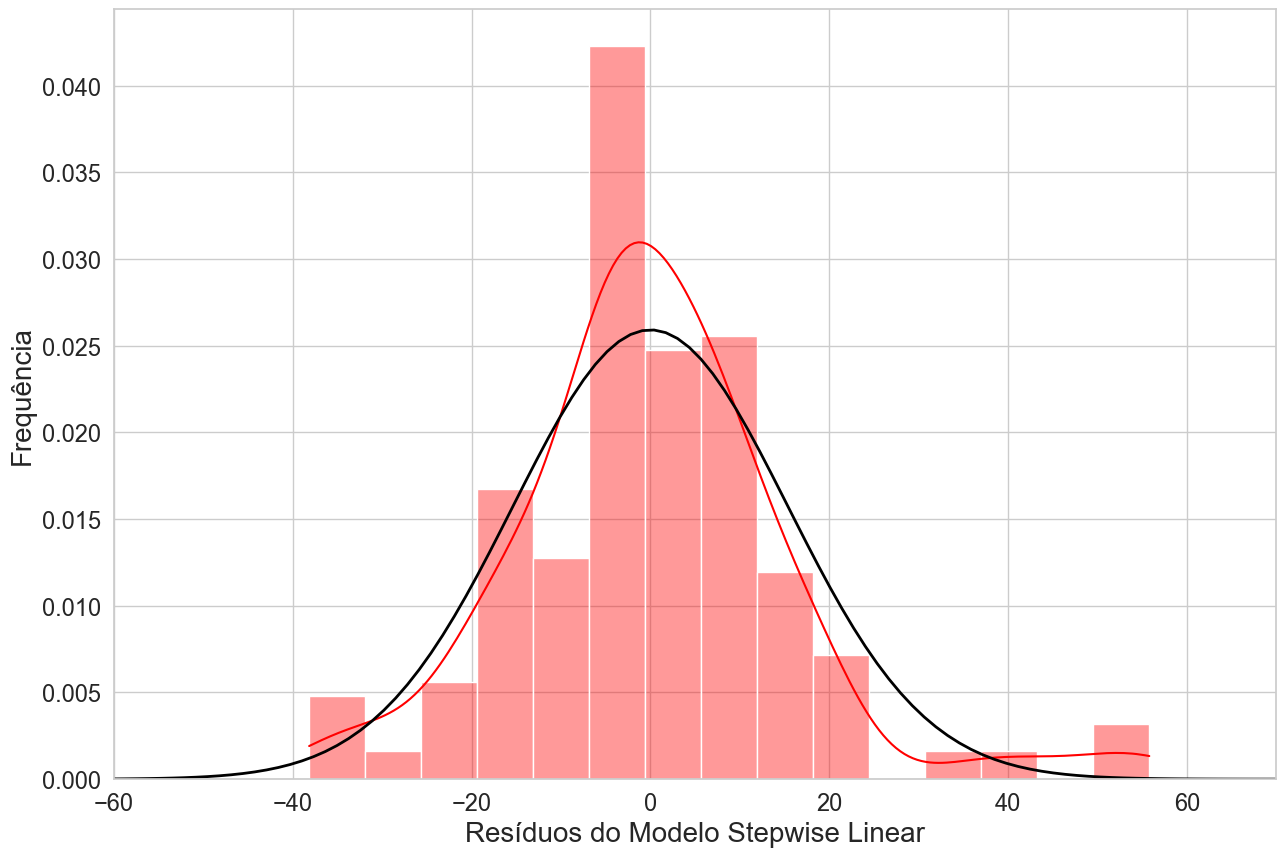

In [12]:
# In[8.7]: Histograma dos resíduos do 'modelo_step_planosaude' com curva normal
# teórica para comparação das distribuições
# Kernel density estimation (KDE) - forma não-paramétrica para estimação da
# função densidade de probabilidade de determinada variável

from scipy.stats import norm

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_planosaude.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_planosaude.resid, bins=15, kde=True, stat="density",
             color='red', alpha=0.4)
plt.xlim(-60, 70)
x = np.linspace(-60, 70, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Stepwise Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

In [13]:
# Função para o teste de Breusch-Pagan para a elaboração de diagnóstico
# de heterocedasticidade

# Criação da função 'breusch_pagan_test'

def breusch_pagan_test(modelo):

    df = pd.DataFrame({'yhat':modelo.fittedvalues,
                       'resid':modelo.resid})
   
    df['up'] = (np.square(df.resid))/np.sum(((np.square(df.resid))/df.shape[0]))
   
    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()
   
    anova_table = sm.stats.anova_lm(modelo_aux, typ=2)
   
    anova_table['sum_sq'] = anova_table['sum_sq']/2
    
    chisq = anova_table['sum_sq'].iloc[0]
   
    p_value = stats.chi2.pdf(chisq, 1)*2
    
    print(f"chisq: {chisq}")
    
    print(f"p-value: {p_value}")
    
    return chisq, p_value

In [14]:
# Teste de Breusch-Pagan propriamente dito

breusch_pagan_test(modelo_step_planosaude)
# Presença de heterocedasticidade -> omissão de variável(is) explicativa(s)
# relevante(s)

# H0 do teste: ausência de heterocedasticidade.
# H1 do teste: heterocedasticidade, ou seja, correlação entre resíduos e
# uma ou mais variáveis explicativas, o que indica omissão de variável relevante!

# Interpretação
teste_bp = breusch_pagan_test(modelo_step_planosaude) #criação do objeto 'teste_bp'
chisq, p = teste_bp #definição dos elementos contidos no objeto 'teste_bp'
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 60.8018249423538
p-value: 6.4125863037360226e-15
chisq: 60.8018249423538
p-value: 6.4125863037360226e-15
Rejeita-se H0 - Existência de Heterocedasticidade


In [15]:
# Adicionando fitted values e resíduos do 'modelo_step_planosaude'
# no dataframe 'df_planosaude_dummies'

df_planosaude_dummies['fitted_step'] = modelo_step_planosaude.fittedvalues
df_planosaude_dummies['residuos_step'] = modelo_step_planosaude.resid
df_planosaude_dummies

,id,despmed,idade,dcron,renda,plano_esmeralda,plano_ouro,fitted_step,residuos_step
0,1,206.84,57,5,57.2,0,0,213.411485,-6.571485
1,2,184.19,67,4,67.2,0,0,204.828144,-20.638144
2,3,175.68,62,4,62.0,0,0,204.828144,-29.148144
3,4,180.04,67,5,67.2,0,0,213.411485,-33.371485
4,5,218.86,68,5,68.0,0,0,213.411485,5.448515
...,...,...,...,...,...,...,...,...,...
195,196,159.02,63,3,63.2,1,0,157.688693,1.331307
196,197,205.35,64,4,64.0,0,0,204.828144,0.521856
197,198,133.64,49,4,48.8,1,0,166.272034,-32.632034
198,199,158.73,44,2,44.0,1,0,149.105352,9.624648


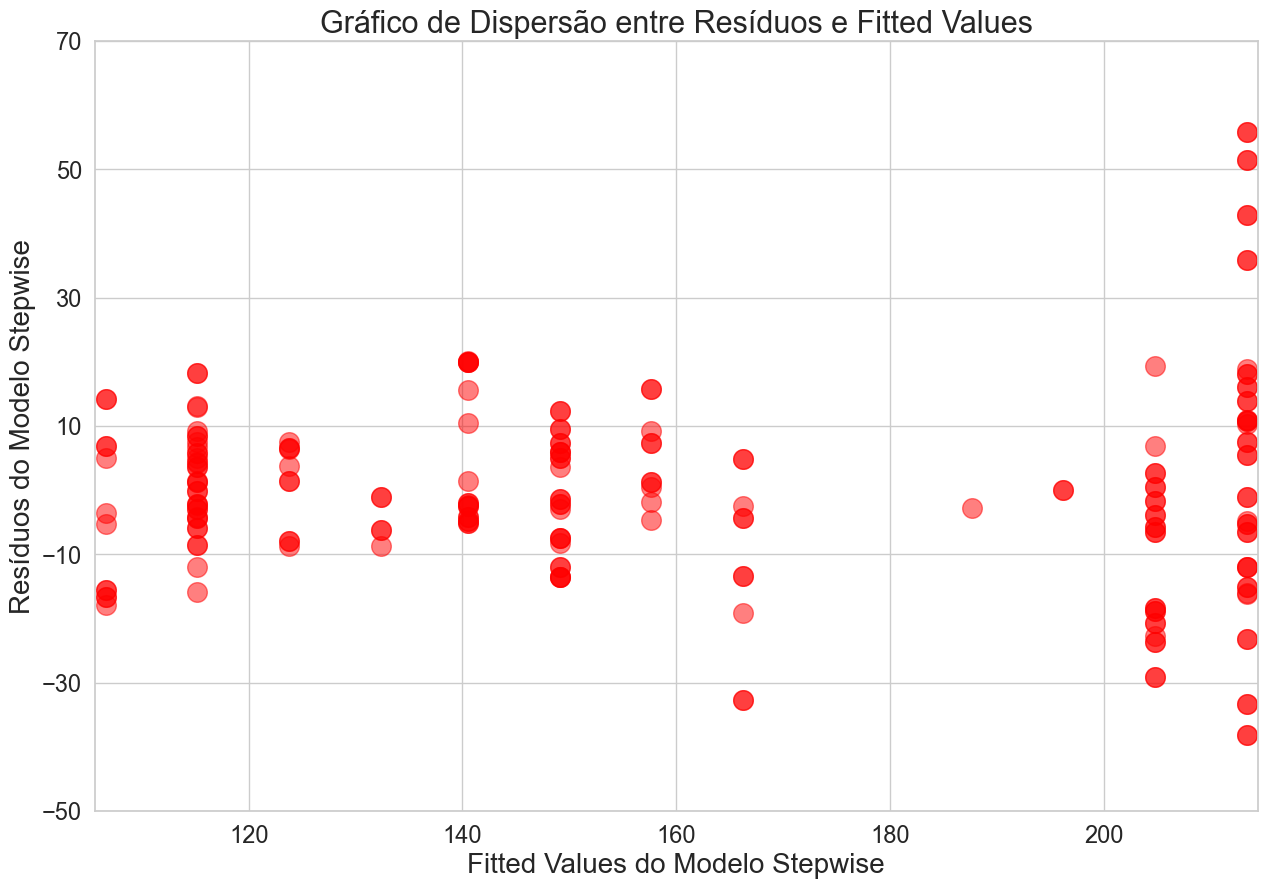

In [16]:
# Gráfico que relaciona resíduos e fitted values do
# 'modelo_step_planosaude'

plt.figure(figsize=(15,10))
sns.regplot(x='fitted_step', y='residuos_step', data=df_planosaude_dummies,
            marker='o', fit_reg=False,
            scatter_kws={"color":'red', 'alpha':0.5, 's':200})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo Stepwise', fontsize=20)
plt.ylabel('Resíduos do Modelo Stepwise', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(np.arange(-50, 71, 20), fontsize=17)
x_min = df_planosaude_dummies['fitted_step'].min()-1
x_max = df_planosaude_dummies['fitted_step'].max()+1
plt.xlim(x_min, x_max)
plt.show()

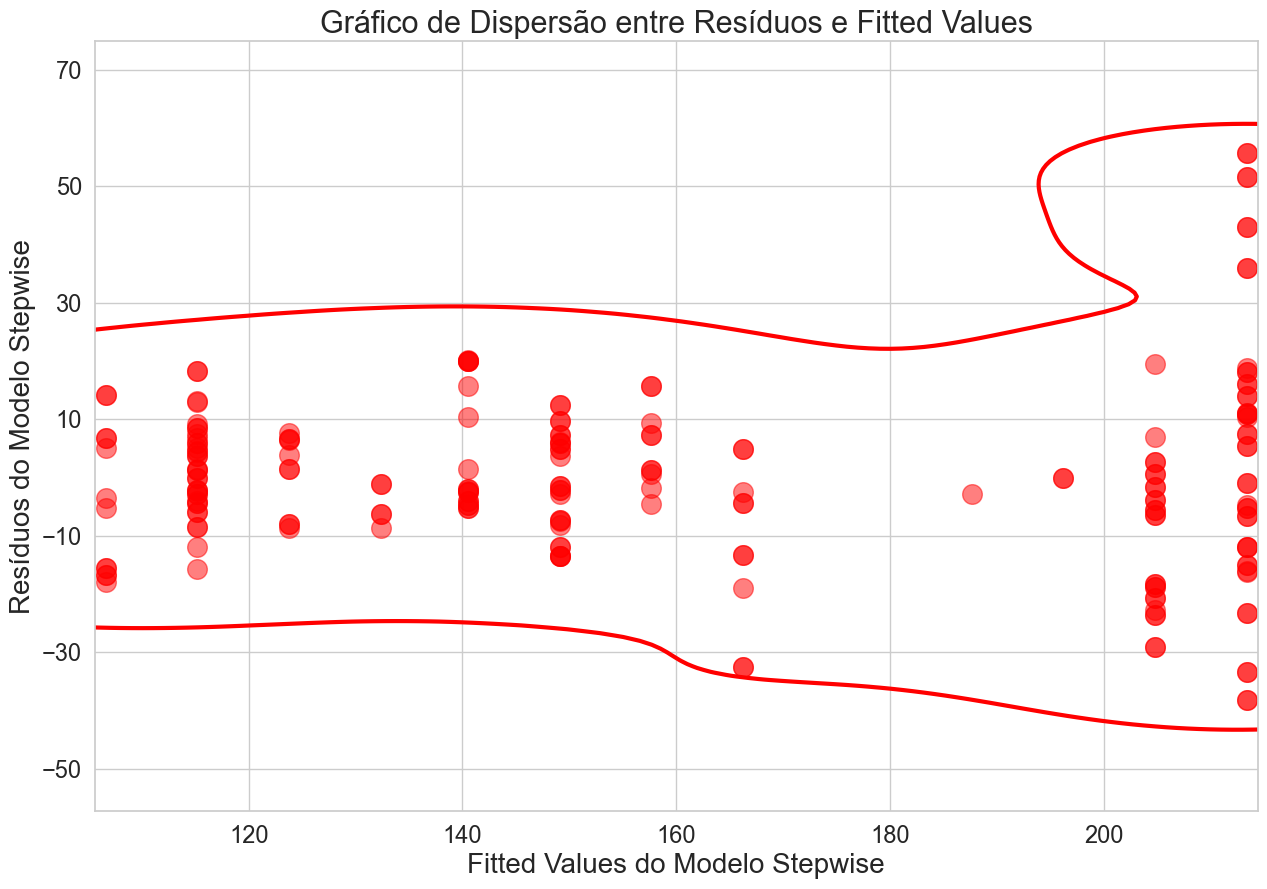

In [17]:
# Gráfico que relaciona resíduos e fitted values do
# 'modelo_step_planosaude', com boundaries

plt.figure(figsize=(15,10))
sns.regplot(x='fitted_step', y='residuos_step', data=df_planosaude_dummies,
            marker='o', fit_reg=False,
            scatter_kws={"color":'red', 'alpha':0.5, 's':200})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo Stepwise', fontsize=20)
plt.ylabel('Resíduos do Modelo Stepwise', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(np.arange(-50, 71, 20), fontsize=17)
x_min = df_planosaude_dummies['fitted_step'].min()-1
x_max = df_planosaude_dummies['fitted_step'].max()+1
plt.xlim(x_min, x_max)

sns.kdeplot(data=df_planosaude_dummies, x='fitted_step', y='residuos_step',
            levels=2, color='red', linewidths=3)

plt.show()

In [18]:
# Transformação de Box-Cox

# Para o cálculo do lambda de Box-Cox
from scipy.stats import boxcox

# 'yast' é uma variável que traz os valores transformados (Y*)
# 'lmbda' é o lambda de Box-Cox
yast, lmbda = boxcox(df_planosaude_dummies['despmed'])

print("Lambda: ",lmbda)

Lambda:  -0.14436737227731805


In [19]:
# Inserindo o lambda de Box-Cox no dataset para a estimação de um
# novo modelo

df_planosaude_dummies['bc_despmed'] = yast
df_planosaude_dummies

# Verificação do cálculo, apenas para fins didáticos
df_planosaude_dummies['bc_despmed2'] = ((df_planosaude_dummies['despmed'])**\
                                        (lmbda) - 1) / (lmbda)
df_planosaude_dummies

del df_planosaude_dummies['bc_despmed2']

In [20]:
# Estimando um novo modelo com todas as variáveis e a variável
# dependente transformada
modelo_bc_planosaude = sm.OLS.from_formula('bc_despmed ~ idade + dcron +\
                                           renda + plano_esmeralda +\
                                               plano_ouro',
                                               df_planosaude_dummies).fit()

# Parâmetros do modelo
print(modelo_bc_planosaude.summary())

                            OLS Regression Results                            
Dep. Variable:             bc_despmed   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     325.5
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.80e-92
Time:                        20:53:53   Log-Likelihood:                 355.33
No. Observations:                 200   AIC:                            -698.7
Df Residuals:                     194   BIC:                            -678.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5507      0.034    1

In [21]:
# Procedimento Stepwise no 'modelo_bc_planosaude'

modelo_step_bc_planosaude = stepwise(modelo_bc_planosaude, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 bc_despmed ~ Q('idade') + Q('dcron') + Q('renda') + Q('plano_esmeralda') + Q('plano_ouro')

 Discarding atribute "Q('renda')" with p-value equal to 0.35652021672048584 

Estimating model...: 
 bc_despmed ~ Q('idade') + Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro')

 Discarding atribute "Q('idade')" with p-value equal to 0.1648116867096376 

Estimating model...: 
 bc_despmed ~ Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('renda')", 'p-value': np.float64(0.35652021672048584)}
{'atribute': "Q('idade')", 'p-value': np.float64(0.1648116867096376)}

 Model after stepwise process...: 
 bc_despmed ~ Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro') 

                            OLS Regression Results                            
Dep. Variable:             bc_despmed   R-squared:                       0.892
Model:               

In [22]:
# Teste de verificação da aderência à normalidade dos resíduos do novo
# 'modelo_step_bc_planosaude'

# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_bc_planosaude.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9868895956266915
statistics z  :  1.5678173710229286
p-value  :  0.05846187985789463
Statistics W=0.98689, p-value=0.058462
Não se rejeita H0 - Distribuição aderente à normalidade


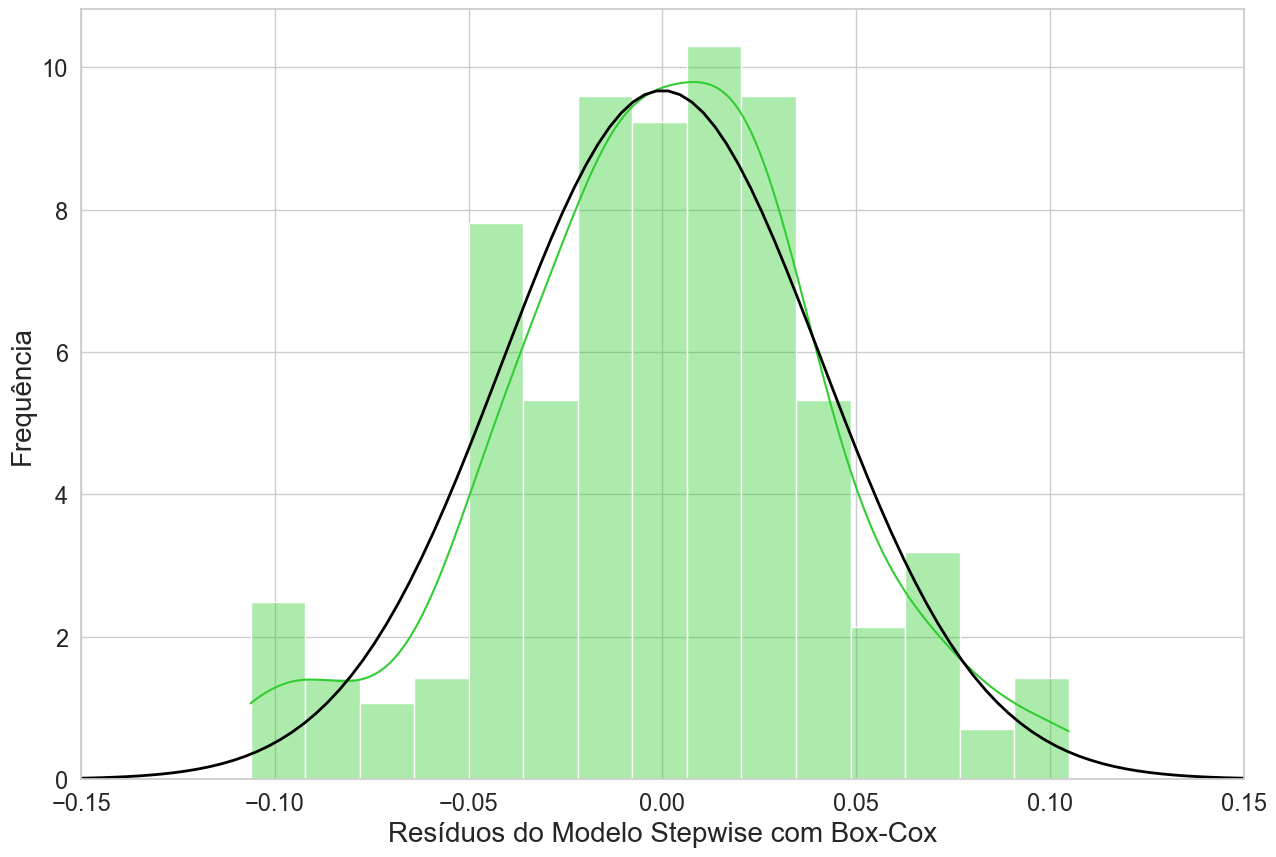

In [23]:
# Histograma dos resíduos do 'modelo_step_bc_planosaude' com curva
# normal teórica para comparação das distribuições
# Kernel density estimation (KDE) - forma não-paramétrica para estimação da
# função densidade de probabilidade de determinada variável

from scipy.stats import norm

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_bc_planosaude.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_bc_planosaude.resid, bins=15, kde=True, stat="density",
             color='limegreen', alpha=0.4)
plt.xlim(-0.15, 0.15)
x = np.linspace(-0.15, 0.15, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Stepwise com Box-Cox', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

In [24]:
# Teste de Breusch-Pagan para diagnóstico de heterocedasticidade
# no 'modelo_step_bc_planosaude'

breusch_pagan_test(modelo_step_bc_planosaude)

# Interpretação
teste_bp = breusch_pagan_test(modelo_step_bc_planosaude) #criação do objeto 'teste_bp'
chisq, p = teste_bp #definição dos elementos contidos no objeto 'teste_bp'
alpha = 0.05 #nível de significância
if p > alpha:
    print('Não se rejeita H0 - Ausência de Heterocedasticidade')
else:
	print('Rejeita-se H0 - Existência de Heterocedasticidade')

chisq: 1.012628758355783
p-value: 0.4778871930468451
chisq: 1.012628758355783
p-value: 0.4778871930468451
Não se rejeita H0 - Ausência de Heterocedasticidade


In [25]:
# Adicionando fitted values e resíduos do 'modelo_step_bc_planosaude'
# no dataframe 'df_planosaude_dummies'

df_planosaude_dummies['fitted_step_bc'] = modelo_step_bc_planosaude.fittedvalues
df_planosaude_dummies['residuos_step_bc'] = modelo_step_bc_planosaude.resid
df_planosaude_dummies

,id,despmed,idade,dcron,renda,plano_esmeralda,plano_ouro,fitted_step,residuos_step,bc_despmed,fitted_step_bc,residuos_step_bc
0,1,206.84,57,5,57.2,0,0,213.411485,-6.571485,3.718813,3.733711,-0.014897
1,2,184.19,67,4,67.2,0,0,204.828144,-20.638144,3.664649,3.706621,-0.041972
2,3,175.68,62,4,62.0,0,0,204.828144,-29.148144,3.642295,3.706621,-0.064325
3,4,180.04,67,5,67.2,0,0,213.411485,-33.371485,3.653899,3.733711,-0.079812
4,5,218.86,68,5,68.0,0,0,213.411485,5.448515,3.744867,3.733711,0.011157
...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,159.02,63,3,63.2,1,0,157.688693,1.331307,3.594710,3.589192,0.005519
196,197,205.35,64,4,64.0,0,0,204.828144,0.521856,3.715463,3.706621,0.008843
197,198,133.64,49,4,48.8,1,0,166.272034,-32.632034,3.510008,3.616282,-0.106274
198,199,158.73,44,2,44.0,1,0,149.105352,9.624648,3.593832,3.562102,0.031730


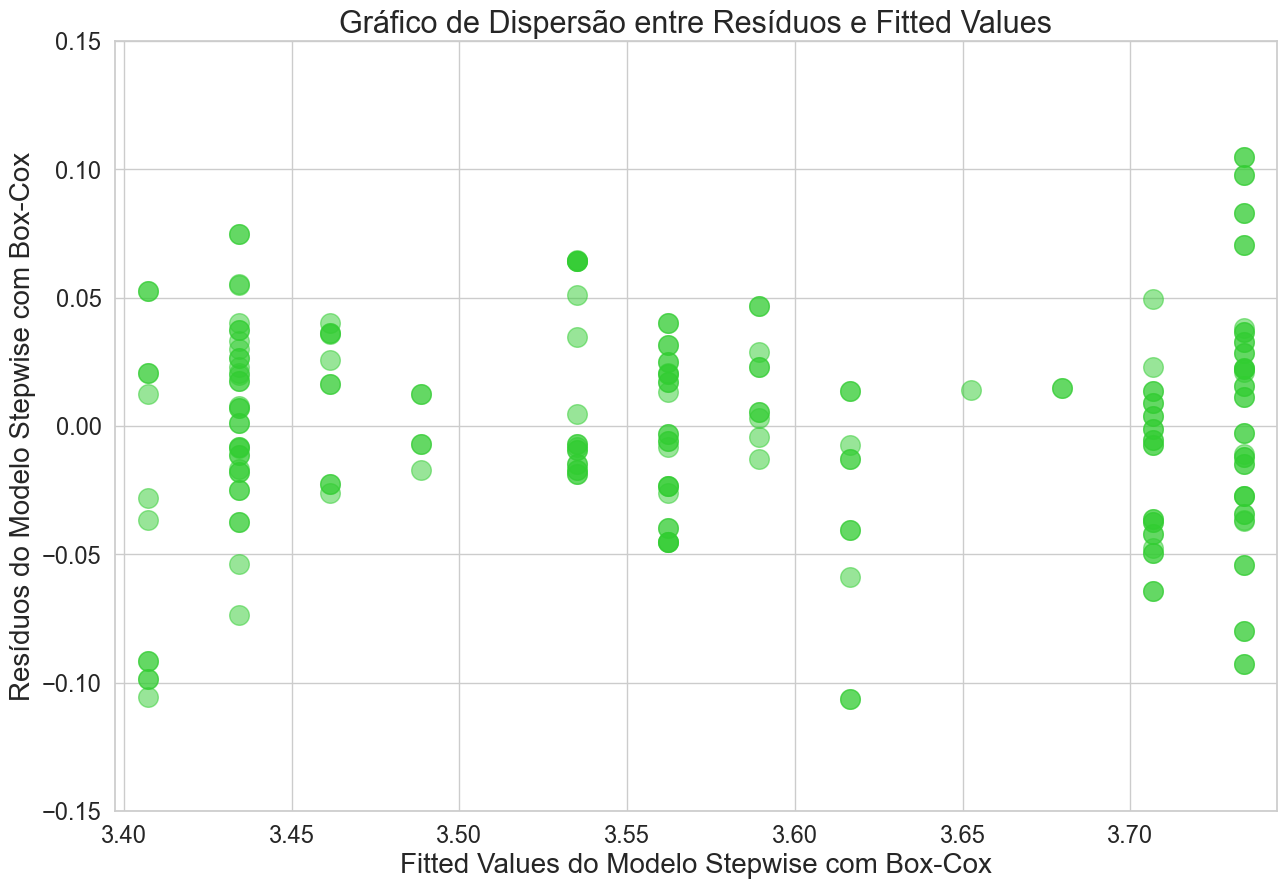

In [26]:
# Gráfico que relaciona resíduos e fitted values do
# 'modelo_step_bc_planosaude'

plt.figure(figsize=(15,10))
sns.regplot(x='fitted_step_bc', y='residuos_step_bc', data=df_planosaude_dummies,
            marker='o', fit_reg=False,
            scatter_kws={"color":'limegreen', 'alpha':0.5, 's':200})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo Stepwise com Box-Cox', fontsize=20)
plt.ylabel('Resíduos do Modelo Stepwise com Box-Cox', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(np.arange(-.15, .16, .05), fontsize=17)
x_min = df_planosaude_dummies['fitted_step_bc'].min()-0.01
x_max = df_planosaude_dummies['fitted_step_bc'].max()+0.01
plt.xlim(x_min, x_max)
plt.show()

<Axes: title={'center': 'Gráfico de Dispersão entre Resíduos e Fitted Values'}, xlabel='Fitted Values do Modelo Stepwise com Box-Cox', ylabel='Resíduos do Modelo Stepwise com Box-Cox'>

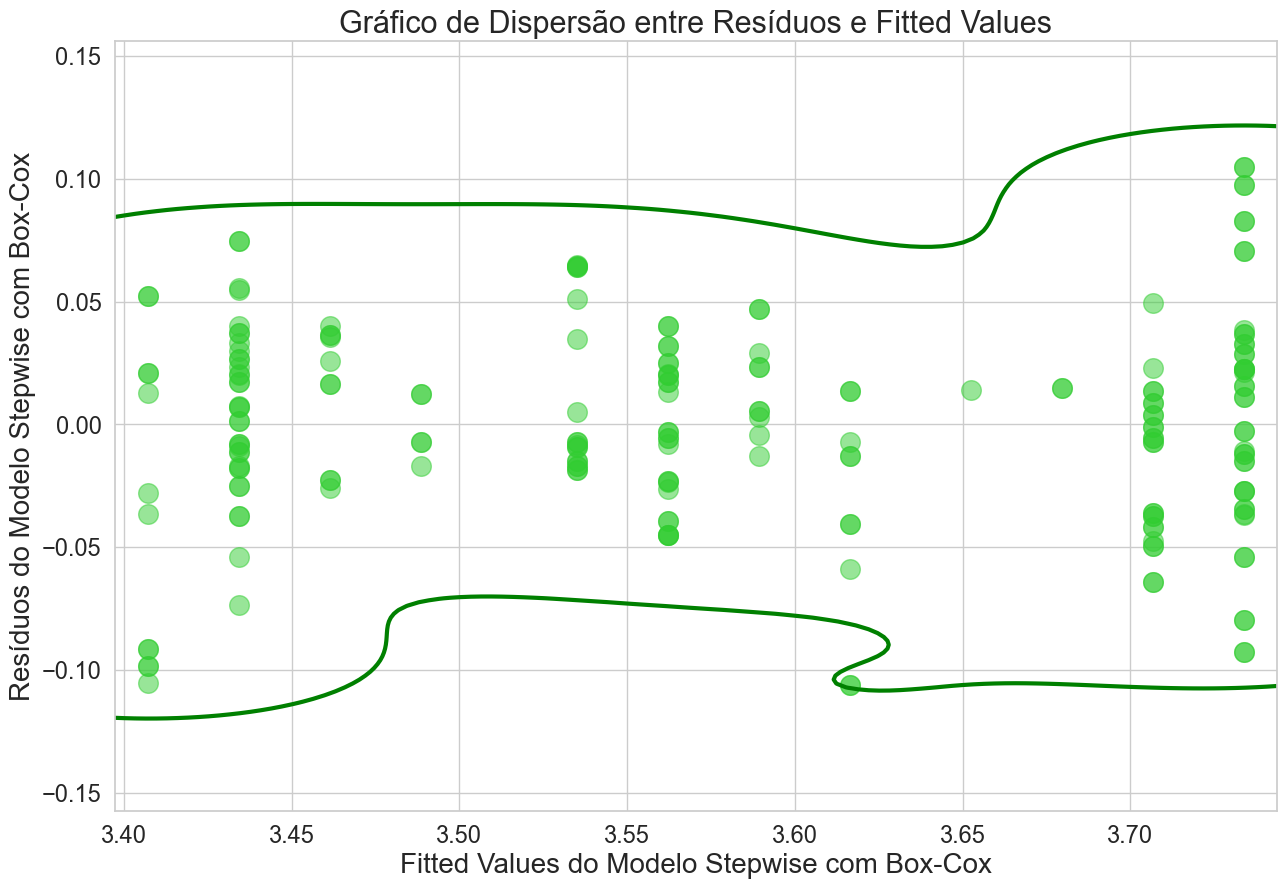

In [27]:
# Gráfico que relaciona resíduos e fitted values do
# 'modelo_step_bc_planosaude', com boundaries

plt.figure(figsize=(15, 10))
sns.regplot(x='fitted_step_bc', y='residuos_step_bc', data=df_planosaude_dummies,
            marker='o', fit_reg=False,
            scatter_kws={"color": 'limegreen', 'alpha': 0.5, 's': 200})
plt.title('Gráfico de Dispersão entre Resíduos e Fitted Values', fontsize=22)
plt.xlabel('Fitted Values do Modelo Stepwise com Box-Cox', fontsize=20)
plt.ylabel('Resíduos do Modelo Stepwise com Box-Cox', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(np.arange(-.15, .16, .05), fontsize=17)
x_min = df_planosaude_dummies['fitted_step_bc'].min()-0.01
x_max = df_planosaude_dummies['fitted_step_bc'].max()+0.01
plt.xlim(x_min, x_max)

sns.kdeplot(data=df_planosaude_dummies, x='fitted_step_bc', y='residuos_step_bc',
            levels=2, color='green', linewidths=3)